# Make and Train a Simple MPNN
Train an MPNN to predict the IC50

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from molgym.mpnn.layers import GraphNetwork, Squeeze
from molgym.mpnn.data import make_data_loader
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import json

## Make the Data Loader
Use a utility function from `molgym.mpnn`

In [2]:
loader = make_data_loader('ic50_dataset.proto', shuffle_buffer=1024)

## Make a Model
Make a simple MPNN

First, determine the size of the atom and bond vocabulary

In [3]:
with open('atom_types.json') as fp:
    atom_type_count = len(json.load(fp))
with open('bond_types.json') as fp:
    bond_type_count = len(json.load(fp))

In [4]:
def build_fn(atom_features=32, message_steps=8):
    node_graph_indices = Input(shape=(1,), name='node_graph_indices', dtype='int32')
    atom_types = Input(shape=(1,), name='atom', dtype='int32')
    bond_types = Input(shape=(1,), name='bond', dtype='int32')
    connectivity = Input(shape=(2,), name='connectivity', dtype='int32')
    
    # Squeeze the node graph and connectivity matrices
    snode_graph_indices = Squeeze(axis=1)(node_graph_indices)
    satom_types = Squeeze(axis=1)(atom_types)
    sbond_types = Squeeze(axis=1)(bond_types)
    
    output = GraphNetwork(atom_type_count, bond_type_count, atom_features,
                          message_steps, name='mpnn')([satom_types, sbond_types, snode_graph_indices, connectivity])
    
    return Model(inputs=[node_graph_indices, atom_types, bond_types, connectivity],
                 outputs=output)

In [5]:
model = build_fn(message_steps=8)

## Train the Model
Train the model using Adam as the optimizer and MSE loss

In [6]:
model.compile('adam', 'mean_squared_error')

In [7]:
history = model.fit(loader, epochs=64, verbose=False)

/home/wardlt/miniconda3/envs/covid_dqn/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wardlt/miniconda3/envs/covid_dqn/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wardlt/miniconda3/envs/covid_dqn/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wardlt/miniconda3/envs/covid_dqn/l

Text(0.5, 0, 'epoch')

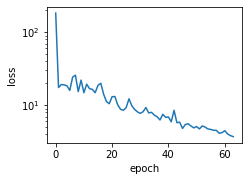

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.semilogy(history.epoch, history.history['loss'])

ax.set_ylabel('loss')
ax.set_xlabel('epoch')

## Validate the Model
Run against the the training set

In [9]:
test_loader = make_data_loader('ic50_dataset.proto')

In [10]:
y_true = np.hstack([x[1].numpy()[:,0] for x in iter(test_loader)])

In [11]:
y_pred = np.squeeze(model.predict(test_loader))

Report some statistics

In [12]:
print(f'R^2: {np.corrcoef(y_true, y_pred)[1, 0] ** 2: .2f}')
print(f'MAE: {np.mean(np.abs(y_pred - y_true)): .2f} (MAD: {np.mean(np.abs(y_true - np.mean(y_true))): .2f})')

R^2:  0.70
MAE:  1.85 (MAD:  3.42)


Text(0, 0.5, 'Log(IC50), MPNN')

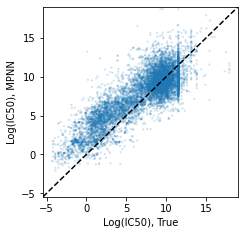

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(y_true, y_pred, s=5, alpha=0.2, edgecolor='none')

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('Log(IC50), True')
ax.set_ylabel('Log(IC50), MPNN')

## Save the Model
For later us

In [14]:
model.save('model.h5')